In [2]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
N = 151
Num_ts = 50000
Vis_ts = 25000
omega = 1

In [4]:
Lx = 1.0; Ly = Lx

In [5]:
# physical density and viscosity of the fluid
rho_p = 965.3; 
nu_p = 0.06/rho_p; 

Re = 500.; # Reynolds number.

In [6]:
# ???

Lo = Ly; # characteristic length
Vo = Re*nu_p/Lo; # characteric velocity for given Renolds Number
To = Lo/Vo; # characteristic time 

# convert to dimensionles units
Td = 1.0;
Ld = 1.0; # for unit spacing and transport of data between lattice sites
Ud = (To/Lo)*Vo; # non-dimensionalized velocity and viscosity
nu_d = 1./float(Re);

In [7]:
#???

# convert non-dimensional units to "lattice units"
dx = 1./(float(N)-1.);
# a little opaque, but this is the correct conversion for time.
dt = (dx**2)*float(Re)*((1./3.)*((1./omega)-0.5)); 
u_lbm = (dt/dx)*Ud;

# get conversion from lattice units to physical units
u_conv_fact = (dx/dt)*(Lo/To); #multiply LBM velocity by u_conv_fact to get physical velocity
t_conv_fact = (dt*To) # multiply LBM time step by t_conv_fact to get physical time
l_conv_fact = dx*Lo # multiply LBM lattice location by l_conv_fact to get physical distance
p_conv_fact = ((l_conv_fact/t_conv_fact)**2.)*(1./3.) # multiply LBM density by p_conv_fact to get pressure
    
rho_lbm = rho_p # not prescribed, but I have never had a problem with doing it this way.

In [8]:
print(f'Lid velocity = %5.4f m/sec' % Vo)
print(f'LBM flow Mach number = %5.4f' % u_lbm)
print(f'Physical time simulated = %6.3f seconds' % 
      (t_conv_fact*(float(Num_ts))))

Lid velocity = 0.0311 m/sec
LBM flow Mach number = 0.5556
Physical time simulated = 5958.642 seconds


In [9]:
#number of nodes in x- and y- direction as well as the total number of nodes
Ny = int(math.ceil((Ly/Lo)*(float(N))));
Nx = int(math.ceil((Lx/Lo)*float(N)));
nnodes = Nx*Ny;

In [10]:
x_left = 0; x_right = x_left+Lx
y_bottom = 0; y_top = y_bottom+Ly
x_space = np.linspace(x_left, x_right, Nx, dtype=np.float64)
y_space = np.linspace(y_bottom, y_top, Ny, dtype=np.float64)
xx, yy = np.meshgrid(x_space, y_space)
gcoord = np.zeros((2,nnodes)) 
gcoord[0][:] = np.reshape(xx,nnodes) # grid x-coords
gcoord[1][:] = np.reshape(yy,nnodes) # grid y-coords

In [19]:
bottom_nodes = np.argwhere(gcoord[1][:]<dx/2.).flatten() # "node indices where y coordinate is small"
left_nodes = np.argwhere(gcoord[0][:]<dx/2.).flatten()
right_nodes = np.argwhere(gcoord[0][:]>(Lx - dx/2.)).flatten()
moving_nodes = np.argwhere(gcoord[1][:]>(Ly - dx/2.)).flatten() # on the lid
solid_nodes = np.unique(np.concatenate((bottom_nodes,left_nodes,right_nodes)))

In [12]:
moving_nodes = np.setxor1d(moving_nodes,np.intersect1d(moving_nodes,solid_nodes)) # removes the solid nodes from the moving nodes

In [13]:
node_type = np.zeros(nnodes).astype(np.int32)
node_type[solid_nodes]=1
node_type[moving_nodes]=2

In [14]:
numSpd = 9;
fIn = np.ones((numSpd,nnodes),dtype=np.float64)
w = np.array([[4./9.], [1./9.],[1./9.],[1./9.],[1./9.],
    [1./36.],[1./36.],[1./36.],[1./36.]]) # weights

#???
for spd in range(numSpd):
    fIn[spd][:]*=rho_lbm*w[spd] # initialize dependent variables
        
fOut = np.copy(fIn) # two copies will be used

ex = np.array([0.,1.,0.,-1.,0.,1.,-1.,-1.,1.]) # lattice velocities 
ey = np.array([0.,0.,1.,0.,-1.,1.,1.,-1.,-1.]) # 9-speed lattice
bb_spd = [0,3,4,1,2,7,8,5,6]; # bounce-back speeds
fEq = np.zeros_like(fIn) # store "equilibrium" densities

#???
snl = solid_nodes
vnl = moving_nodes
u = u_lbm

In [15]:
# make a stream target matrix - incorporate periodicity to the lattice here.
stm = np.zeros((numSpd,nnodes),dtype=np.int32)
    
ind = np.arange(nnodes)
ind = np.reshape(ind,(Ny,Nx))
for spd in range(numSpd):
    tInd = np.roll(ind,-int(ex[spd]),axis=1)
    tInd = np.roll(tInd,-int(ey[spd]),axis=0)
    tInd = np.reshape(tInd,(1,nnodes))
    stm[spd][:] = tInd

In [18]:
np.shape(np.transpose(ex))

(9,)

Commencing time step 0
Commencing time step 5000
Commencing time step 10000
Commencing time step 15000
Commencing time step 20000
Commencing time step 25000


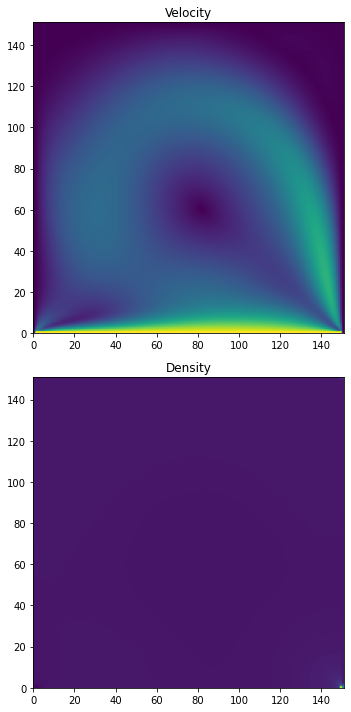

Commencing time step 30000
Commencing time step 35000
Commencing time step 40000
Commencing time step 45000
Lattice point updates per second = 7.36012e+06.


In [370]:
# commence time stepping
t0 = time.time()
for t in range(Num_ts):
    if t%5000 == 0:
        print(f'Commencing time step %i' % t);
           
            
    # ???
    # compute density
    rho = np.sum(fIn,axis=0)
    # compute velocity
    ux = np.dot(np.transpose(ex),fIn)/rho
    uy = np.dot(np.transpose(ey),fIn)/rho
    
    # ???
    # set microscopic Dirichlet-type BC
    ux_t = ux[vnl]; uy_t = uy[vnl];
    dx = u - ux_t; dy = 0. - uy_t;
    for spd in range(1,numSpd):
        cu = 3.*(ex[spd]*dx + ey[spd]*dy)
        
        fIn[spd][vnl]+=w[spd]*(rho[vnl]*cu)
               
    # set macroscopic Dirichlet-type boundary conditions
    ux[snl]=0.; uy[snl]=0.
    ux[vnl]=u; uy[vnl]=0.
        
    # compute Equilibrium density distribution
    fEq = np.zeros_like(fIn)
    
    # just some equation?
    for spd in range(numSpd):
        cu = 3.*(ex[spd]*ux + ey[spd]*uy)
        fEq[spd][:]=w[spd]*rho*(1.+cu + (0.5)*cu*cu -
                                (3./2.)*(ux*ux + uy*uy))
            
    # collide
    fOut = fIn - (fIn - fEq)*omega
        
    # bounce-back the solid nodes 
    for spd in range(numSpd):
        fOut[spd][snl]=fIn[bb_spd[spd]][snl]
    
    # ???
    # stream
    for spd in range(numSpd):
        fIn[spd][stm[spd][:]]=fOut[spd][:]
        
        
    # write fIn data out after time step
    #np.save('step1_gold',fIn)
            
    if t%Vis_ts==0 and t>0:
        # do some visualization of the output
        uMag = np.sqrt(ux*ux + uy*uy)
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(6,10))
        ax1.imshow(np.reshape(uMag,(Ny,Nx)),extent=[0,Nx,0,Ny])
        ax1.set_title('Velocity')
        pressure = rho*p_conv_fact
        pressure -= pressure[int(nnodes/2)] # make pressure relative
        ax2.imshow(np.reshape(pressure,(Ny,Nx)),extent=[0,Nx,0,Ny])
        ax2.set_title('Density')
        plt.tight_layout()
        plt.show()
            
        
t1 = time.time();
elapsedTime = t1 - t0;
LPU = float(nnodes)*float(Num_ts)
LPU_sec = LPU/float(elapsedTime)
print(f'Lattice point updates per second = %g.' % LPU_sec)